In [ ]:
!pip install pykrx

In [ ]:
from pykrx import stock
from pykrx import bond
df = stock.get_market_cap("20240913")
top200_df = df.nlargest(200, '시가총액').sort_index()
top200_df.index

Index(['000080', '000100', '000120', '000150', '000240', '000250', '000270',
       '000660', '000720', '000810',
       ...
       '377300', '383220', '395400', '402340', '403870', '443060', '450080',
       '454910', '457190', '462870'],
      dtype='object', name='티커', length=200)

In [ ]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

tickers = top200_df.index

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def compute_returns(df):
    df['Close'].fillna(method='ffill', inplace=True)

    # 수익률 계산
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

def load_and_preprocess_data(ticker):
    file_path = f'/content/drive/My Drive/ticker_data/{ticker}_features.csv'

    df = pd.read_csv(file_path, index_col=0)

    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    df = compute_returns(df)

    # 타깃 설정
    features = df.drop(columns=['Close', 'Return'])
    target = df['Return']

    feature_names = features.columns.tolist()

    # 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    # 텐서로 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, feature_names

# 예시로 티커 '000080' 데이터를 불러오는 코드 실행
ticker = '000080'
X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data(ticker)

if X_train is None:
    print("데이터가 없거나 처리할 수 없습니다.")
else:
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("Feature names:", feature_names)

X_train shape: torch.Size([2363, 19])
y_train shape: torch.Size([2363])
Feature names: ['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', 'SMA_20', 'EMA_20', 'Momentum_10', 'RSI_14', 'STD_20', 'Upper_Band', 'Lower_Band', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'ATR_14', 'Volume_MA_20']


<ipython-input-41-9eda27fa8683>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'].fillna(method='ffill', inplace=True)


## 1. LSTM을 통한 생성기 설계
- 수익률을 예측하는 LSTM 기반의 생성기 모델 설계

In [ ]:
def create_sequences(input_data, target_data, seq_length):
    sequences = []
    targets = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    for i in range(len(input_data) - seq_length):
        sequences.append(input_data[i:i+seq_length])
        targets.append(target_data[i+seq_length])

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

seq_length = 20
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

In [ ]:
class GeneratorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GeneratorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

input_size = X_train_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

generator = GeneratorLSTM(input_size, hidden_size, num_layers, output_size)

## 2. CNN을 통한 판별기 설계
- CNN을 이용한 판별기는 생성된 수익률 예측값과 실제 값을 구분하는 역할을 수행함
- 1차원 CNN을 사용하여 데이터를 처리함

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_seq, y_train_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, input_size):
        super(DiscriminatorCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2)
        self.fc1 = nn.Linear(32 * (input_size - 2 - 2 + 2), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(x))
        return out


input_size = X_train_seq.shape[1]
discriminator = DiscriminatorCNN(input_size)

## 평가 지표

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred, returns):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

y_pred = generator(X_test_seq).detach().numpy()
returns = y_test_seq.numpy()

evaluate_model(y_test_seq, y_pred, returns)

MSE: 0.0008446052670478821
MAE: 0.024323107674717903
RMSE: 0.029062094166874886


(0.00084460527, 0.024323108, 0.029062094)

## 1. LSTM 생성기 모델

In [ ]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random

# 튜닝할 하이퍼파라미터 범위 설정
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.5],
    'epochs': [10, 20, 50]
}

# 모델 훈련 함수
def train_model(params, X_train, y_train, X_test, y_test):
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']
    epochs = params['epochs']

    # LSTM 모델 정의
    class TuningLSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
            super(TuningLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            lstm_out = lstm_out[:, -1, :]  # 마지막 타임스텝 출력 사용
            out = self.fc(lstm_out)
            return out

    # 모델 초기화
    input_size = X_train.shape[2]  # 입력 크기 (피처 수)
    output_size = 1  # 출력 크기 (수익률 예측)
    model = TuningLSTM(input_size, hidden_size, num_layers, output_size, dropout)

    # 손실 함수 및 옵티마이저 정의
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 훈련
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        # 검증 데이터로 평가
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs.squeeze(), y_test)

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    # 최종 검증 손실 반환
    return val_loss.item()

# Random search로 하이퍼파라미터 튜닝
def random_search(param_grid, X_train, y_train, X_test, y_test, n_iter=10):
    best_loss = float('inf')
    best_params = None

    for i in range(n_iter):
        params = {key: random.choice(values) for key, values in param_grid.items()}
        print(f"\nRunning model with params: {params}")

        val_loss = train_model(params, X_train, y_train, X_test, y_test)

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            print(f"New best model found with loss: {best_loss}")

    return best_params, best_loss

# Random search 실행
best_params, best_loss = random_search(param_grid, X_train_seq, y_train_seq, X_test_seq, y_test_seq, n_iter=10)

print(f"Best hyperparameters: {best_params}, Best validation loss: {best_loss}")


Running model with params: {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.01, 'batch_size': 64, 'dropout': 0.2, 'epochs': 50}
Epoch [0/50], Loss: 0.002559325657784939, Val Loss: 0.01770772598683834
Epoch [10/50], Loss: 0.0011318207252770662, Val Loss: 0.0010946623515337706
Epoch [20/50], Loss: 0.0004142876423429698, Val Loss: 0.0004353516560513526
Epoch [30/50], Loss: 0.0003508708323352039, Val Loss: 0.00041854174924083054
Epoch [40/50], Loss: 0.00034121485077776015, Val Loss: 0.000404794467613101
New best model found with loss: 0.00039571014349348843

Running model with params: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.01, 'batch_size': 64, 'dropout': 0.5, 'epochs': 50}
Epoch [0/50], Loss: 0.0067342547699809074, Val Loss: 0.20539842545986176
Epoch [10/50], Loss: 0.0017847095150500536, Val Loss: 0.0008193566463887691
Epoch [20/50], Loss: 0.00041904987301677465, Val Loss: 0.0005073113716207445
Epoch [30/50], Loss: 0.0004766930069308728, Val Loss: 0.0004222591815

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 0.0006871141376905143, Val Loss: 0.0007940891664475203
Epoch [20/50], Loss: 0.0004934144672006369, Val Loss: 0.0005270224646665156
Epoch [30/50], Loss: 0.00037045206408947706, Val Loss: 0.00044494500616565347
Epoch [40/50], Loss: 0.00033406150760129094, Val Loss: 0.00040610102587379515

Running model with params: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.2, 'epochs': 20}
Epoch [0/20], Loss: 0.008380887098610401, Val Loss: 0.00459753954783082
Epoch [10/20], Loss: 0.0006122075137682259, Val Loss: 0.0004467839899007231

Running model with params: {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 128, 'dropout': 0.3, 'epochs': 20}
Epoch [0/20], Loss: 0.026986896991729736, Val Loss: 0.021662810817360878
Epoch [10/20], Loss: 0.001211262191645801, Val Loss: 0.0007684556185267866

Running model with params: {'hidden_size': 32, 'num_layers': 2, 'learning_rate': 0.01, 'batch_size': 32, 'dropout': 0.5,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [0/20], Loss: 0.008103215135633945, Val Loss: 0.0759301409125328
Epoch [10/20], Loss: 0.0022645818535238504, Val Loss: 0.002238600980490446

Running model with params: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.5, 'epochs': 20}
Epoch [0/20], Loss: 0.014799402095377445, Val Loss: 0.009904278442263603
Epoch [10/20], Loss: 0.0018773699412122369, Val Loss: 0.0013691928470507264

Running model with params: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 128, 'dropout': 0.2, 'epochs': 20}
Epoch [0/20], Loss: 0.0038576729129999876, Val Loss: 0.013052624650299549
Epoch [10/20], Loss: 0.0006473856628872454, Val Loss: 0.0007061813957989216

Running model with params: {'hidden_size': 32, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'epochs': 20}
Epoch [0/20], Loss: 0.04669409617781639, Val Loss: 0.04104890674352646
Epoch [10/20], Loss: 0.011909933760762215, Val Loss: 0.009469004347920418

- LSTM 베스트 파라미터

In [ ]:
# LSTM 생성기 모델 정의 (dropout 추가)
class GeneratorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(GeneratorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력 사용
        out = self.fc(lstm_out)
        return out

# 최적의 하이퍼파라미터 적용
best_hidden_size = 32
best_num_layers = 2
best_learning_rate = 0.01
best_dropout = 0.5
best_batch_size = 32
best_epochs = 50

# LSTM 생성기 모델 초기화
generator = GeneratorLSTM(input_size=X_train_seq.shape[2], hidden_size=best_hidden_size,
                          num_layers=best_num_layers, output_size=1, dropout=best_dropout)

# 손실 함수 및 옵티마이저 정의
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=best_learning_rate)

# DataLoader 설정
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_seq, y_train_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# 모델 학습 함수
def train_lstm_model(generator, train_loader, num_epochs):
    generator.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = generator(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    return generator

# 최적의 파라미터로 학습 실행
trained_generator = train_lstm_model(generator, train_loader, best_epochs)

Epoch [10/50], Loss: 0.000268
Epoch [20/50], Loss: 0.000080
Epoch [30/50], Loss: 0.000337
Epoch [40/50], Loss: 0.000090
Epoch [50/50], Loss: 0.000196


In [ ]:
# X_train_seq, X_test_seq의 차원이 올바른지 확인
print(X_train_seq.shape)  # 출력 확인

# 차원이 2차원이라면 3차원으로 변환
if X_train_seq.dim() == 2:
    X_train_seq = X_train_seq.unsqueeze(1)  # (batch_size, 1, sequence_length)
    X_test_seq = X_test_seq.unsqueeze(1)

# DiscriminatorCNN에서 Conv1d 입력 차원 맞추기
class DiscriminatorCNN(nn.Module):
    def __init__(self, input_size, conv1_channels, conv2_channels, kernel_size):
        super(DiscriminatorCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)

        # Conv1d 출력 크기 계산
        def conv_output_size(input_size, kernel_size, stride=1, padding=0):
            return (input_size - kernel_size + 2 * padding) // stride + 1

        conv1_output_size = conv_output_size(input_size, kernel_size)  # 시퀀스 길이
        conv2_output_size = conv_output_size(conv1_output_size, kernel_size)

        # Linear 레이어의 입력 크기
        self.fc1 = nn.Linear(conv2_channels * conv2_output_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # (batch_size, feature_size, sequence_length) -> (batch_size, 1, sequence_length)
        x = x.unsqueeze(1)  # 3D 텐서로 변환
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(x))
        return out

torch.Size([2343, 20, 19])


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 모델 평가 지표: RMSE, R², MSE, MAE, 샤프 비율, 최대 손실(Max Drawdown)
def evaluate_model_performance(y_true, y_pred):
    # MSE, MAE, RMSE 및 R² 계산
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # 결과 출력
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

# 예측 및 성능 평가
y_pred = trained_generator(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

# 모델 성능 평가
evaluate_model_performance(y_test_actual, y_pred)

MSE: 0.00044470065040513873
MAE: 0.015618260949850082
RMSE: 0.021087925881147385


(0.00044470065, 0.015618261, 0.021087926)

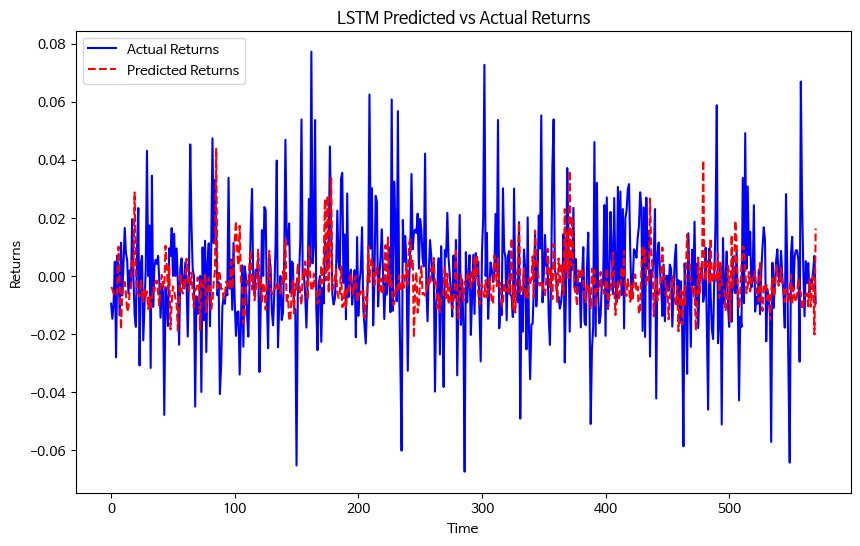

In [ ]:
# LSTM 모델 예측
y_pred = generator(X_test_seq).detach().numpy()  # 예측된 수익률
y_test_actual = y_test_seq.numpy()  # 실제 수익률

import matplotlib.pyplot as plt

# 예측 값과 실제 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Returns', color='blue')  # 실제 값 (수익률)
plt.plot(y_pred, label='Predicted Returns', color='red', linestyle='--')  # 예측 값 (수익률)
plt.title('LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

## CNN-LSTM MODEL

In [ ]:
import torch
import torch.nn as nn

# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # CNN 부분 (특성 추출)
        # x의 형태: (batch_size, sequence_length, feature_size)
        x = x.permute(0, 2, 1)  # (batch_size, feature_size, sequence_length)으로 변환
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # LSTM 부분 (시퀀스 학습)
        # Conv1D 이후 shape: (batch_size, conv_output_size, sequence_length)
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, conv_output_size)으로 변환
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

In [ ]:
# 모델 초기화
conv1_channels = 32
conv2_channels = 64
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.3

cnn_lstm_model = CNN_LSTM(input_size=X_train_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                          output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                          kernel_size=kernel_size, dropout=dropout)

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# DataLoader 설정 (LSTM과 동일)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN + LSTM 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

# CNN + LSTM 모델 학습
num_epochs = 50
trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)

Epoch [10/50], Loss: 0.000263
Epoch [20/50], Loss: 0.000168
Epoch [30/50], Loss: 0.000120
Epoch [40/50], Loss: 0.000103
Epoch [50/50], Loss: 0.000041


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 모델 평가 지표: RMSE, R², MSE, MAE
def evaluate_model_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

# 예측 및 성능 평가
y_pred = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

# 모델 성능 평가
evaluate_model_performance(y_test_actual, y_pred)

MSE: 0.0006574030267074704
MAE: 0.019533753395080566
RMSE: 0.025639871135354042


(0.000657403, 0.019533753, 0.025639871)

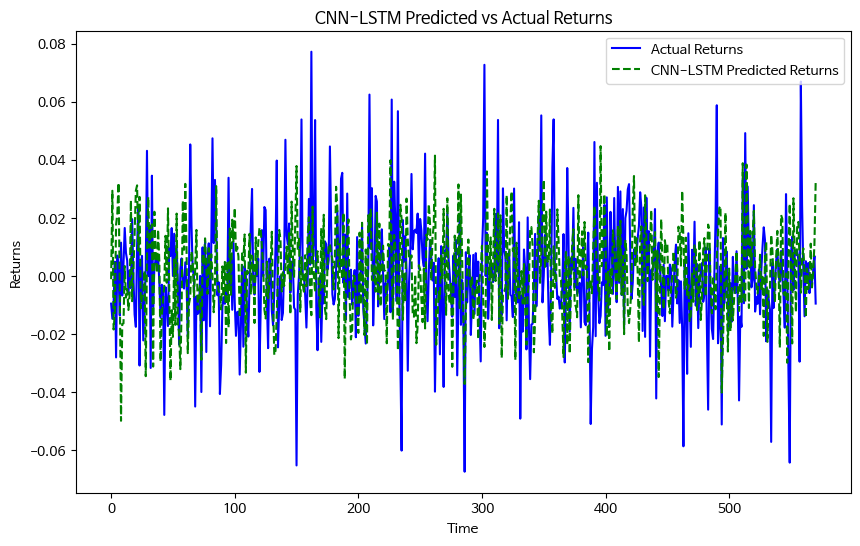

In [ ]:
import matplotlib.pyplot as plt

y_pred_cnn_lstm = trained_cnn_lstm_model(X_test_seq).detach().numpy()  # CNN-LSTM 예측된 수익률
y_test_actual = y_test_seq.numpy()  # 실제 수익률

# 예측 값과 실제 값 시각화
plt.figure(figsize=(10, 6))

# 실제 수익률
plt.plot(y_test_actual, label='Actual Returns', color='blue')

# CNN-LSTM 모델 예측 수익률
plt.plot(y_pred_cnn_lstm, label='CNN-LSTM Predicted Returns', color='green', linestyle='--')

plt.title('CNN-LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

plt.show()

In [ ]:
import random
import torch.optim as optim

# CNN-LSTM 모델 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid = {
    'conv1_channels': [16, 32, 64],
    'conv2_channels': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'dropout': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.005, 0.01],
    'batch_size': [32, 64, 128],
    'epochs': [20, 50]
}

# CNN-LSTM 모델 학습 함수
def train_cnn_lstm_model(params, X_train, y_train, X_test, y_test):
    # 파라미터 설정
    conv1_channels = params['conv1_channels']
    conv2_channels = params['conv2_channels']
    kernel_size = params['kernel_size']
    dropout = params['dropout']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # CNN-LSTM 모델 초기화
    cnn_lstm_model = CNN_LSTM(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                              output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                              kernel_size=kernel_size, dropout=dropout)

    # 손실 함수 및 옵티마이저 정의
    criterion = nn.MSELoss()
    optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

    # DataLoader 설정
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 모델 학습
    cnn_lstm_model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = cnn_lstm_model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

    # 최종 검증 데이터 손실 계산
    cnn_lstm_model.eval()
    with torch.no_grad():
        y_test_pred = cnn_lstm_model(X_test)
        val_loss = criterion(y_test_pred.squeeze(), y_test)

    return val_loss.item()

# Random search로 CNN-LSTM 하이퍼파라미터 튜닝
def random_search_cnn_lstm(param_grid, X_train, y_train, X_test, y_test, n_iter=10):
    best_loss = float('inf')
    best_params = None

    for i in range(n_iter):
        # 무작위로 파라미터 선택
        params = {key: random.choice(values) for key, values in param_grid.items()}
        print(f"\nRunning model with params: {params}")

        val_loss = train_cnn_lstm_model(params, X_train, y_train, X_test, y_test)

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            print(f"New best model found with loss: {best_loss}")

    return best_params, best_loss

# Random search 실행
best_params, best_loss = random_search_cnn_lstm(param_grid, X_train_seq, y_train_seq, X_test_seq, y_test_seq, n_iter=10)

print(f"Best Parameters: {best_params}, Best Loss: {best_loss}")


Running model with params: {'conv1_channels': 64, 'conv2_channels': 32, 'kernel_size': 2, 'dropout': 0.5, 'learning_rate': 0.005, 'batch_size': 64, 'epochs': 20}
Epoch [10/20], Loss: 0.000294
Epoch [20/20], Loss: 0.000298
New best model found with loss: 0.000440095056546852

Running model with params: {'conv1_channels': 64, 'conv2_channels': 32, 'kernel_size': 4, 'dropout': 0.5, 'learning_rate': 0.005, 'batch_size': 128, 'epochs': 50}
Epoch [10/50], Loss: 0.000381
Epoch [20/50], Loss: 0.000243
Epoch [30/50], Loss: 0.000494
Epoch [40/50], Loss: 0.000427
Epoch [50/50], Loss: 0.000449
New best model found with loss: 0.00039492614450864494

Running model with params: {'conv1_channels': 32, 'conv2_channels': 64, 'kernel_size': 4, 'dropout': 0.3, 'learning_rate': 0.005, 'batch_size': 32, 'epochs': 50}
Epoch [10/50], Loss: 0.000165
Epoch [20/50], Loss: 0.000162
Epoch [30/50], Loss: 0.000250
Epoch [40/50], Loss: 0.000102
Epoch [50/50], Loss: 0.000093

Running model with params: {'conv1_channe

- Best Parameter

In [ ]:
# 최적의 하이퍼파라미터 대입
conv1_channels = 32
conv2_channels = 32
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.01
batch_size = 64
num_epochs = 20

# CNN + LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, feature_size) -> (batch_size, feature_size, sequence_length)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # (batch_size, conv_output_size, sequence_length) -> (batch_size, sequence_length, conv_output_size)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

# 모델 초기화
cnn_lstm_model = CNN_LSTM(input_size=X_train_seq.shape[2], hidden_size=hidden_size, num_layers=num_layers,
                           output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                           kernel_size=kernel_size, dropout=dropout)

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

# DataLoader 설정
train_dataset = TensorDataset(X_train_seq, y_train_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN + LSTM 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

# CNN + LSTM 모델 학습
trained_cnn_lstm_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs)

Epoch [10/20], Loss: 0.000311
Epoch [20/20], Loss: 0.000346


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 모델 평가 지표: RMSE, MSE, MAE
def evaluate_model_performance(y_true, y_pred):
    # MSE, MAE, RMSE
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # 결과 출력
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

y_pred = trained_cnn_lstm_model(X_test_seq).detach().numpy()
y_test_actual = y_test_seq.numpy()

evaluate_model_performance(y_test_seq.numpy(), y_pred)

MSE: 0.00041452268487773836
MAE: 0.014807515777647495
RMSE: 0.020359830930829048


(0.00041452268, 0.014807516, 0.02035983)

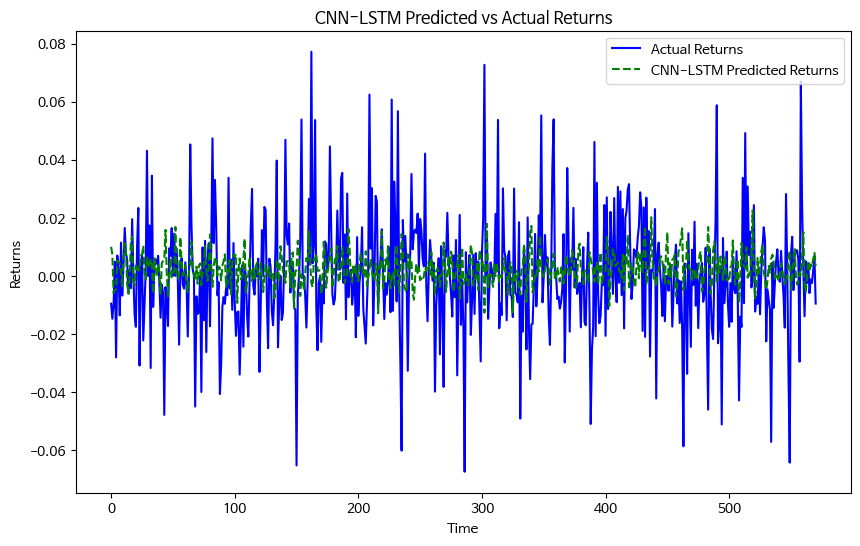

In [ ]:
import matplotlib.pyplot as plt

y_pred_cnn_lstm = trained_cnn_lstm_model(X_test_seq).detach().numpy()  # CNN-LSTM 예측된 수익률
y_test_actual = y_test_seq.numpy()  # 실제 수익률

# 예측 값과 실제 값 시각화
plt.figure(figsize=(10, 6))

# 실제 수익률
plt.plot(y_test_actual, label='Actual Returns', color='blue')

# CNN-LSTM 모델 예측 수익률
plt.plot(y_pred_cnn_lstm, label='CNN-LSTM Predicted Returns', color='green', linestyle='--')

plt.title('CNN-LSTM Predicted vs Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

plt.show()

## Importance

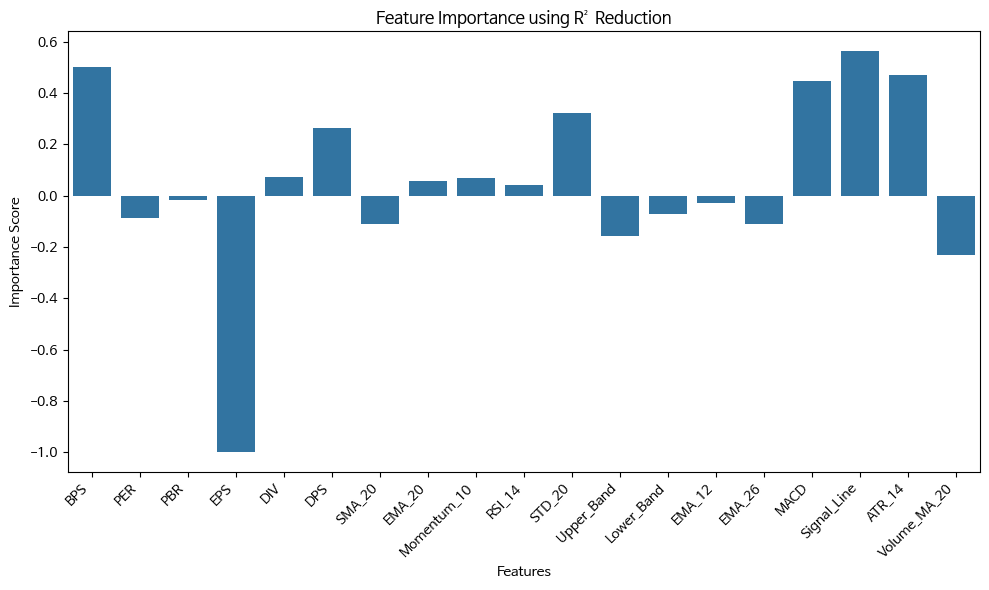

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# R² 감소법을 사용하여 변수 중요도를 계산하는 함수
def calculate_r2_feature_importance(model, X_test, y_test, feature_names):
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        # 원본 데이터를 이용해 R² 계산
        y_pred = model(X_test).squeeze(1).detach().numpy()  # 모델 예측
        baseline_r2 = r2_score(y_test.numpy(), y_pred)  # 기본 R²

    feature_importances = []

    # 각 피처를 0으로 설정하고 R² 감소량을 계산
    for i in range(X_test.shape[2]):  # 피처 수만큼 반복
        X_test_zeroed = X_test.clone()  # X_test 복사본 생성
        X_test_zeroed[:, :, i] = 0  # i번째 피처를 0으로 설정

        # 수정된 피처로 다시 예측값 계산
        with torch.no_grad():
            y_pred_zeroed = model(X_test_zeroed).squeeze(1).detach().numpy()

        reduced_r2 = r2_score(y_test.numpy(), y_pred_zeroed)  # 수정된 피처로 R² 재계산
        importance = baseline_r2 - reduced_r2  # 중요도는 R² 감소량
        feature_importances.append(importance)

    # 중요도 값을 표준화 (합이 1이 되도록)
    feature_importances = np.array(feature_importances)
    feature_importances /= np.sum(feature_importances)

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=feature_importances)
    plt.title('Feature Importance using R² Reduction')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_importances

# LSTM 모델 평가 후 피처 중요도 계산
importance_scores = calculate_r2_feature_importance(generator, X_test_seq, y_test_seq, feature_names)


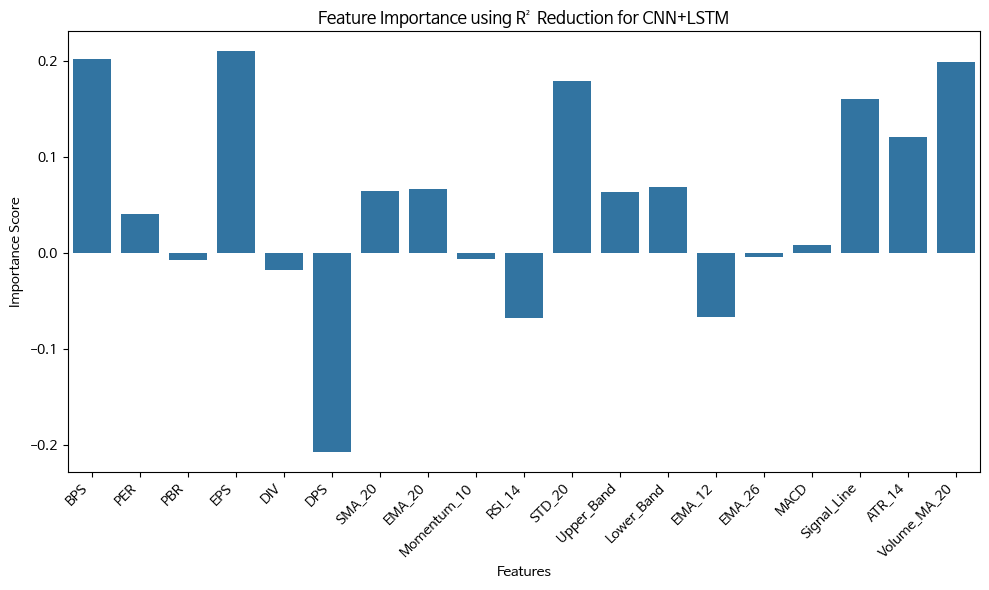

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# R² 감소법을 사용하여 변수 중요도를 계산하는 함수
def calculate_r2_feature_importance(model, X_test, y_test, feature_names):
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        # 원본 데이터를 이용해 R² 계산
        y_pred = model(X_test).squeeze(1).detach().numpy()  # 모델 예측
        baseline_r2 = r2_score(y_test.numpy(), y_pred)  # 기본 R²

    feature_importances = []

    # 각 피처를 0으로 설정하고 R² 감소량을 계산
    for i in range(X_test.shape[2]):  # 피처 수만큼 반복
        X_test_zeroed = X_test.clone()  # X_test 복사본 생성
        X_test_zeroed[:, :, i] = 0  # i번째 피처를 0으로 설정

        # 수정된 피처로 다시 예측값 계산
        with torch.no_grad():
            y_pred_zeroed = model(X_test_zeroed).squeeze(1).detach().numpy()

        reduced_r2 = r2_score(y_test.numpy(), y_pred_zeroed)  # 수정된 피처로 R² 재계산
        importance = baseline_r2 - reduced_r2  # 중요도는 R² 감소량
        feature_importances.append(importance)

    # 중요도 값을 표준화 (합이 1이 되도록)
    feature_importances = np.array(feature_importances)
    feature_importances /= np.sum(feature_importances)

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=feature_importances)
    plt.title('Feature Importance using R² Reduction for CNN+LSTM')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_importances

# CNN+LSTM 모델 평가 후 피처 중요도 계산
importance_scores = calculate_r2_feature_importance(cnn_lstm_model, X_test_seq, y_test_seq, feature_names)

Feature Importance Scores:
BPS: 0.2015
PER: 0.0398
PBR: -0.0081
EPS: 0.2099
DIV: -0.0176
DPS: -0.2073
SMA_20: 0.0643
EMA_20: 0.0665
Momentum_10: -0.0068
RSI_14: -0.0680
STD_20: 0.1792
Upper_Band: 0.0629
Lower_Band: 0.0688
EMA_12: -0.0674
EMA_26: -0.0045
MACD: 0.0076
Signal_Line: 0.1601
ATR_14: 0.1210
Volume_MA_20: 0.1983


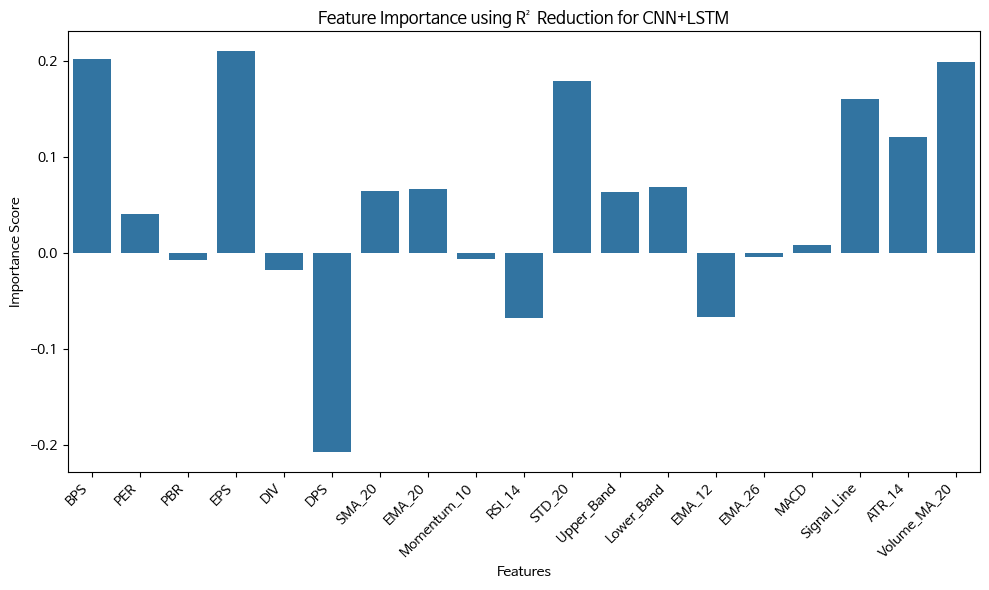

In [ ]:
import numpy as np
import torch
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# R² 감소법을 사용하여 변수 중요도를 계산하는 함수
def calculate_r2_feature_importance(model, X_test, y_test, feature_names):
    model.eval()  # 평가 모드로 전환
    with torch.no_grad():
        # 원본 데이터를 이용해 R² 계산
        y_pred = model(X_test).squeeze(1).detach().numpy()  # 모델 예측
        baseline_r2 = r2_score(y_test.numpy(), y_pred)  # 기본 R²

    feature_importances = []

    # 각 피처를 0으로 설정하고 R² 감소량을 계산
    for i in range(X_test.shape[2]):  # 피처 수만큼 반복
        X_test_zeroed = X_test.clone()  # X_test 복사본 생성
        X_test_zeroed[:, :, i] = 0  # i번째 피처를 0으로 설정

        # 수정된 피처로 다시 예측값 계산
        with torch.no_grad():
            y_pred_zeroed = model(X_test_zeroed).squeeze(1).detach().numpy()

        reduced_r2 = r2_score(y_test.numpy(), y_pred_zeroed)  # 수정된 피처로 R² 재계산
        importance = baseline_r2 - reduced_r2  # 중요도는 R² 감소량
        feature_importances.append(importance)

    # 중요도 값을 표준화 (합이 1이 되도록)
    feature_importances = np.array(feature_importances)
    feature_importances /= np.sum(feature_importances)

    # 변수 중요도 출력
    print("Feature Importance Scores:")
    for feature_name, importance_score in zip(feature_names, feature_importances):
        print(f"{feature_name}: {importance_score:.4f}")

    # 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=feature_importances)
    plt.title('Feature Importance using R² Reduction for CNN+LSTM')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return feature_importances

# CNN+LSTM 모델 평가 후 피처 중요도 계산
importance_scores = calculate_r2_feature_importance(cnn_lstm_model, X_test_seq, y_test_seq, feature_names)

## **포트폴리오 구성**

## 평균 predict

In [1]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 11.0 MB/s eta 0:00:00


In [2]:
# 새로운 티커를 찾기 위해 데이터를 새롭게 가공
from pykrx import stock
from pykrx import bond
df = stock.get_market_cap("20240913")
top200_df = df.nlargest(200, '시가총액').sort_index()
top200_df.index

Index(['000080', '000100', '000120', '000150', '000240', '000250', '000270',
       '000660', '000720', '000810',
       ...
       '377300', '383220', '395400', '402340', '403870', '443060', '450080',
       '454910', '457190', '462870'],
      dtype='object', name='티커', length=200)

In [4]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

tickers = top200_df.index

Mounted at /content/drive


In [8]:
import os
import shutil
import pandas as pd

# 디렉토리 생성
output_dir = '/content/drive/My Drive/ticker_data_2024/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [9]:
# 티커 리스트를 가져옵니다
tickers = top200_df.index

In [10]:
# 티커별 데이터 처리 함수
def process_ticker_data(ticker):
    # 펀더멘털 데이터 가져오기
    fund_df = stock.get_market_fundamental("20200102", "20240910", ticker)

    # OHLCV 데이터 가져오기 (기술적 지표를 위한 데이터)
    ohlcv_df = stock.get_market_ohlcv("20200102", "20240910", ticker)
    ohlcv_df.index.name = 'Date'
    ohlcv_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']

    # 기술적 지표 계산
    tech_df = pd.DataFrame(index=ohlcv_df.index)

    # 종가를 피처로 추가
    tech_df['Close'] = ohlcv_df['Close']

    # 이동 평균 (SMA, EMA)
    tech_df['SMA_20'] = ohlcv_df['Close'].rolling(window=20).mean()
    tech_df['EMA_20'] = ohlcv_df['Close'].ewm(span=20, adjust=False).mean()

    # 모멘텀 (Momentum)
    tech_df['Momentum_10'] = ohlcv_df['Close'] - ohlcv_df['Close'].shift(10)

    # RSI
    delta = ohlcv_df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    tech_df['RSI_14'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    tech_df['SMA_20'] = ohlcv_df['Close'].rolling(window=20).mean()
    tech_df['STD_20'] = ohlcv_df['Close'].rolling(window=20).std()
    tech_df['Upper_Band'] = tech_df['SMA_20'] + (tech_df['STD_20'] * 2)
    tech_df['Lower_Band'] = tech_df['SMA_20'] - (tech_df['STD_20'] * 2)

    # MACD
    tech_df['EMA_12'] = ohlcv_df['Close'].ewm(span=12, adjust=False).mean()
    tech_df['EMA_26'] = ohlcv_df['Close'].ewm(span=26, adjust=False).mean()
    tech_df['MACD'] = tech_df['EMA_12'] - tech_df['EMA_26']
    tech_df['Signal_Line'] = tech_df['MACD'].ewm(span=9, adjust=False).mean()

    # Average True Range
    high_low = ohlcv_df['High'] - ohlcv_df['Low']
    high_close = (ohlcv_df['High'] - ohlcv_df['Close'].shift()).abs()
    low_close = (ohlcv_df['Low'] - ohlcv_df['Close'].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    tech_df['ATR_14'] = true_range.rolling(window=14).mean()

    # Volume Moving Average
    tech_df['Volume_MA_20'] = ohlcv_df['Volume'].rolling(window=20).mean()

    # 펀더멘털과 기술적 지표를 합칩니다
    final_df = pd.concat([fund_df, tech_df], axis=1)

    # CSV로 저장
    file_path = os.path.join(output_dir, f'{ticker}_features.csv')
    final_df.to_csv(file_path)
    print(f'{ticker} 데이터 저장 완료: {file_path}')

# 모든 티커에 대해 데이터 처리 및 저장
for ticker in tickers:
    process_ticker_data(ticker)

000080 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000080_features.csv
000100 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000100_features.csv
000120 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000120_features.csv
000150 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000150_features.csv
000240 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000240_features.csv
000250 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000250_features.csv
000270 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000270_features.csv
000660 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000660_features.csv
000720 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000720_features.csv
000810 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000810_features.csv
000880 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000880_features.csv
000990 데이터 저장 완료: /content/drive/My Drive/ticker_data_2024/000990_features.csv
001040 데이터 저장 완료: /content/drive/My Drive/ticker_dat

## 일자별 계산

In [16]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import time

In [17]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [18]:
def compute_returns(df):
    df['Close'] = df['Close'].ffill()
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

In [27]:
# 데이터 로드 및 전처리 함수 (2020년 이후의 데이터만 사용)
def load_and_preprocess_data_with_all_features(ticker):
    try:
        file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_features.csv'
        df = pd.read_csv(file_path, index_col=0)

        # 필수 컬럼이 없는 경우 경고 출력
        if 'Close' not in df.columns:
            print(f"Warning: 'Close' column not found for ticker {ticker}. Skipping...")
            return None, None, None, None

        # 2020년 이후의 데이터만 필터링
        df.index = pd.to_datetime(df.index)
        df = df[df.index >= '2020-01-01']

        # 데이터가 충분히 존재하는지 확인
        if len(df) < 20:  # 시퀀스 길이보다 짧은 데이터는 무시
            print(f"Insufficient data for ticker {ticker} after 2020. Skipping...")
            return None, None, None, None

        # 수익률 계산 및 모든 피처 사용
        df = compute_returns(df)

        # 결측치 존재 여부 확인
        if df.isnull().values.any():
            print(f"Missing values found in ticker {ticker}. Filling forward...")
            df = df.fillna(method='ffill').dropna()

        features = df.drop(columns=['Close', 'Return'])  # 모든 피처 사용
        target = df['Return']

        # 데이터 표준화
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # 텐서로 변환
        X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
        y_tensor = torch.tensor(target.values, dtype=torch.float32)

        return X_tensor, y_tensor, features.columns.tolist(), df.index

    except Exception as e:
        print(f"Error processing data for ticker {ticker}: {e}")
        return None, None, None, None

# 피처 이름이 잘 설정되었는지 확인
selected_features = select_all_features(feature_names)

# 모든 피처를 사용하여 데이터 로드 및 전처리 수행 (2020년 이후의 데이터만)
ticker = '000080'  # 예시 티커
X_tensor, y_tensor, selected_feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)

# 출력 확인
if X_tensor is not None:
    print("X_tensor shape:", X_tensor.shape)
    print("사용된 피처:", selected_feature_names)
else:
    print("Fail: 데이터 로드 실패")

X_tensor shape: torch.Size([1140, 19])
사용된 피처: ['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', 'SMA_20', 'EMA_20', 'Momentum_10', 'RSI_14', 'STD_20', 'Upper_Band', 'Lower_Band', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'ATR_14', 'Volume_MA_20']


In [40]:
# 데이터 로드 및 전처리 함수 (2020년 이후의 데이터만 사용)
def load_and_preprocess_data(ticker):
    file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    # 2020년 이후의 데이터만 필터링
    df.index = pd.to_datetime(df.index)
    df = df[df.index >= '2020-01-01']

    # 데이터가 충분히 존재하는지 확인
    if len(df) < 20:  # 시퀀스 길이보다 짧은 데이터는 무시
        print(f"Insufficient data for ticker {ticker} after 2020. Skipping...")
        return None, None, None, None

    # 수익률 계산 및 모든 피처 사용
    df = compute_returns(df)

    # 결측치 존재 여부 확인
    if df.isnull().values.any():
        print(f"Missing values found in ticker {ticker}. Filling forward...")
        df = df.fillna(method='ffill').dropna()

    features = df.drop(columns=['Close', 'Return'])  # 모든 피처 사용
    target = df['Return']

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 텐서로 변환
    X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(target.values, dtype=torch.float32)

    return X_tensor, y_tensor, features.columns.tolist(), df.index

In [41]:
# 시퀀스 생성 함수 (날짜 인덱스 추가)
def create_sequences_for_all_dates(input_data, target_data, seq_length, date_index):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대한 루프문
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(date_index[i])  # 날짜 인덱스 추가

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

In [42]:
# CNN-LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

In [43]:
# 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

In [44]:
# 예측 수익률을 저장하는 함수 (날짜 처리 수정)
def add_predicted_returns_to_file(ticker, model, seq_length=20):
    X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data(ticker)
    if X_tensor is None:
        print(f"{ticker} 데이터를 처리할 수 없습니다.")
        return

    # 시퀀스 데이터 생성 (날짜 인덱스를 추가로 사용하여 dates 생성)
    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, seq_length, date_index)

    # dates가 날짜 문자열인지 확인하고 정수 인덱스로 변환
    try:
        dates = [date_index.get_loc(date) for date in dates]  # 날짜를 정수 인덱스로 변환
    except KeyError:
        print(f"{ticker}의 dates 배열에 date_index에 없는 날짜가 포함되어 있습니다.")
        return

    # dates가 인덱스 범위를 초과하는 경우 처리
    if max(dates) >= len(date_index):
        dates = [i for i in dates if i < len(date_index)]
        print(f"잘못된 dates 수정 후 길이: {len(dates)}")

    # 모델 평가 모드로 설정
    model.eval()
    with torch.no_grad():
        y_pred = model(X_seq).squeeze().numpy()

    # 날짜 인덱스를 사용해 예측 날짜 가져오기
    pred_dates = date_index[dates]

    # 예측 수익률과 실제 수익률을 데이터프레임으로 저장
    result_df = pd.DataFrame({
        'Date': pred_dates,  # 시퀀스의 마지막 날짜 사용
        'Predicted_Return': y_pred,
        'Actual_Return': y_seq.numpy()
    })

    # 파일로 저장
    result_file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장했습니다.")

# 수정된 시퀀스 생성 함수
def create_sequences_for_all_dates(input_data, target_data, seq_length, date_index):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대한 루프문
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(date_index[i])  # 날짜 인덱스 사용

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

In [45]:
# 최적의 하이퍼파라미터 대입
conv1_channels = 32
conv2_channels = 32
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.01
batch_size = 64
num_epochs = 20

# 모델 초기화
cnn_lstm_model = CNN_LSTM(input_size=19, hidden_size=hidden_size, num_layers=num_layers,
                           output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                           kernel_size=kernel_size, dropout=dropout)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

# 데이터 준비 및 학습
ticker = '000080'  # 예시 티커
result = load_and_preprocess_data(ticker)

if result is None:
    print("Data loading failed.")
else:
    X_tensor, y_tensor, feature_names, date_index = result

    # 날짜 인덱스를 포함하여 시퀀스 생성
    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, seq_length=20, date_index=date_index)

    train_dataset = TensorDataset(X_seq, y_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    start_time = time.time()
    trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer)
    print(f"학습 시간: {time.time() - start_time:.2f} 초")

    # 예측 수익률을 파일에 저장
    add_predicted_returns_to_file(ticker, trained_model, seq_length=20)

Epoch [10/20], Loss: 0.000194
Epoch [20/20], Loss: 0.000138
학습 시간: 7.75 초
000080의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2024/000080_predicted_returns.csv에 저장했습니다.


### 개별 데이터들에 대해 실행

In [60]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [61]:
def compute_returns(df):
    df['Close'] = df['Close'].ffill()
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

In [62]:
# 피처 중요도 기반으로 학습 데이터 피처를 선별하지 않고 모든 피처를 사용하게 수정
def select_all_features(feature_names):
    return feature_names

# 데이터 로드 및 전처리 함수 (2020년 이후의 데이터만 사용)
def load_and_preprocess_data_with_all_features(ticker):
    file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    # 2020년 이후의 데이터만 필터링
    df.index = pd.to_datetime(df.index)  # 인덱스를 datetime 형식으로 변환
    df = df[df.index >= '2020-01-01']  # 2020년 이후의 데이터만 선택

    # 수익률 계산 및 모든 피처 사용
    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])  # 모든 피처 사용
    target = df['Return']  # 수익률을 타깃으로 설정

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 텐서로 변환
    X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(target.values, dtype=torch.float32)

    return X_tensor, y_tensor, features.columns.tolist(), df.index

# 모든 피처를 사용하도록 선택
selected_features = select_all_features(feature_names)

# 모든 피처를 사용하여 데이터 로드 및 전처리 수행 (2020년 이후의 데이터만)
ticker = '000080'  # 예시 티커
X_tensor, y_tensor, selected_feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)

if X_tensor is not None:
    print("X_tensor shape:", X_tensor.shape)
    print("사용된 피처:", selected_feature_names)
else:
    print("Fail")

X_tensor shape: torch.Size([1140, 19])
사용된 피처: ['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', 'SMA_20', 'EMA_20', 'Momentum_10', 'RSI_14', 'STD_20', 'Upper_Band', 'Lower_Band', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'ATR_14', 'Volume_MA_20']


In [63]:
# 시퀀스 생성 함수 (날짜 인덱스 추가)
def create_sequences_for_all_dates(input_data, target_data, seq_length, date_index):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대한 루프문
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(date_index[i])  # 날짜 인덱스 추가

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

In [64]:
# CNN-LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

In [65]:
# 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')
    return model

In [66]:
# 예측 수익률을 저장하는 함수 (날짜 처리 수정)
def add_predicted_returns_to_file(ticker, model, seq_length=20):
    X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data(ticker)
    if X_tensor is None:
        print(f"{ticker} 데이터를 처리할 수 없습니다.")
        return

    # 시퀀스 데이터 생성 (날짜 인덱스를 추가로 사용하여 dates 생성)
    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, seq_length, date_index)

    # dates가 날짜 문자열인지 확인하고 정수 인덱스로 변환
    try:
        dates = [date_index.get_loc(date) for date in dates]  # 날짜를 정수 인덱스로 변환
    except KeyError:
        print(f"{ticker}의 dates 배열에 date_index에 없는 날짜가 포함되어 있습니다.")
        return

    # dates가 인덱스 범위를 초과하는 경우 처리
    if max(dates) >= len(date_index):
        dates = [i for i in dates if i < len(date_index)]
        print(f"잘못된 dates 수정 후 길이: {len(dates)}")

    # 모델 평가 모드로 설정
    model.eval()
    with torch.no_grad():
        y_pred = model(X_seq).squeeze().numpy()

    # 날짜 인덱스를 사용해 예측 날짜 가져오기
    pred_dates = date_index[dates]

    # 예측 수익률과 실제 수익률을 데이터프레임으로 저장
    result_df = pd.DataFrame({
        'Date': pred_dates,  # 시퀀스의 마지막 날짜 사용
        'Predicted_Return': y_pred,
        'Actual_Return': y_seq.numpy()
    })

    # 파일로 저장
    result_file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장했습니다.")

# 수정된 시퀀스 생성 함수
def create_sequences_for_all_dates(input_data, target_data, seq_length, date_index):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대한 루프문
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(date_index[i])  # 날짜 인덱스 사용

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

In [67]:
# 최적의 하이퍼파라미터 대입
conv1_channels = 32
conv2_channels = 32
kernel_size = 3
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.5
learning_rate = 0.01
batch_size = 64
num_epochs = 20

# 모델 초기화
cnn_lstm_model = CNN_LSTM(input_size=19, hidden_size=hidden_size, num_layers=num_layers,
                           output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                           kernel_size=kernel_size, dropout=dropout)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

# 데이터 준비 및 학습
ticker = '000080'  # 예시 티커
X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data(ticker)

# 날짜 인덱스를 포함하여 시퀀스 생성
X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, seq_length=20, date_index=date_index)

train_dataset = TensorDataset(X_seq, y_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

start_time = time.time()
trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer)
print(f"학습 시간: {time.time() - start_time:.2f} 초")

# 예측 수익률을 파일에 저장
add_predicted_returns_to_file(ticker, trained_model, seq_length=20)

Epoch [10/20], Loss: 0.000339
Epoch [20/20], Loss: 0.000524
학습 시간: 8.19 초
000080의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2024/000080_predicted_returns.csv에 저장했습니다.


In [68]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 모델 성능 평가 함수
def evaluate_model_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

    return mse, mae, rmse

# 모델을 평가 모드로 전환
trained_model.eval()

# 예측 수행
with torch.no_grad():
    y_pred = trained_model(X_seq).detach().numpy()  # 학습된 모델로 예측
    y_test_actual = y_seq.numpy()  # 실제 수익률 값

# 모델 성능 평가 실행
evaluate_model_performance(y_test_actual, y_pred)

MSE: 0.00037730479380115867
MAE: 0.013674610294401646
RMSE: 0.019424334168434143


(0.0003773048, 0.01367461, 0.019424334)

In [69]:
import pandas as pd

# 예측 및 실제 수익률 파일 경로
file_path = '/content/drive/My Drive/ticker_data_2024/000080_predicted_returns.csv'

# CSV 파일 불러오기
predicted_returns_df = pd.read_csv(file_path)

# 불러온 데이터 확인
print(predicted_returns_df.tail(10))
print("Shape of the DataFrame:", predicted_returns_df.shape)

            Date  Predicted_Return  Actual_Return
1110  2024-08-28         -0.004268      -0.018605
1111  2024-08-29         -0.004268      -0.018957
1112  2024-08-30         -0.004268       0.000000
1113  2024-09-02         -0.004268      -0.002415
1114  2024-09-03         -0.004268       0.009685
1115  2024-09-04         -0.004268      -0.011990
1116  2024-09-05         -0.004268      -0.007282
1117  2024-09-06         -0.004268       0.002445
1118  2024-09-09         -0.004268       0.002439
1119  2024-09-10         -0.004268      -0.007299
Shape of the DataFrame: (1120, 3)


### 모든 티커들에 대해 실행

In [70]:
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import time

# CNN-LSTM 모델 정의
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, conv1_channels, conv2_channels, kernel_size, dropout):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=conv2_channels, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 마지막 시퀀스 출력
        out = self.fc(lstm_out)
        return out

# 시퀀스 생성 함수 (2020년 이후의 데이터 사용)
def create_sequences_for_all_dates(input_data, target_data, date_index, seq_length):
    sequences = []
    targets = []
    dates = []

    input_data = input_data.numpy() if isinstance(input_data, torch.Tensor) else input_data
    target_data = target_data.numpy() if isinstance(target_data, torch.Tensor) else target_data

    # 모든 날짜에 대해 시퀀스 생성
    for i in range(seq_length, len(input_data)):
        sequences.append(input_data[i-seq_length:i])
        targets.append(target_data[i])
        dates.append(i)  # 날짜 인덱스 저장

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), dates

In [71]:
# 모든 피처 사용을 위한 데이터 로드 및 전처리 함수 (2020년 이후의 데이터만 사용)
def load_and_preprocess_data_with_all_features(ticker):
    file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_features.csv'
    df = pd.read_csv(file_path, index_col=0)
    if 'Close' not in df.columns:
        print(f"Warning: 'Close' column not found for ticker {ticker}.")
        return None, None, None, None

    # 2020년 이후의 데이터만 필터링
    df.index = pd.to_datetime(df.index)  # 인덱스를 datetime 형식으로 변환
    df = df[df.index >= '2020-01-01']  # 2020년 이후의 데이터만 선택

    # 수익률 계산 및 모든 피처 사용
    df = compute_returns(df)
    features = df.drop(columns=['Close', 'Return'])  # 모든 피처 사용
    target = df['Return']  # 수익률을 타깃으로 설정

    # 데이터 표준화
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 텐서로 변환
    X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(target.values, dtype=torch.float32)

    return X_tensor, y_tensor, features.columns.tolist(), df.index

In [72]:
# 모델 학습 함수
def train_cnn_lstm_model(model, train_loader, num_epochs, criterion, optimizer, checkpoint_interval, checkpoint_dir, ticker):
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        # 지정한 간격으로 체크포인트 저장
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'{ticker}_epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f} - Checkpoint saved to {checkpoint_path}")
    return model

# 예측 수익률을 저장하는 함수
def add_predicted_returns_to_file(ticker, model, seq_length=20):
    # 데이터 로드 및 전처리
    X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
    if X_tensor is None:
        print(f"{ticker} 데이터를 처리할 수 없습니다.")
        return

    # 모든 날짜별 시퀀스 데이터 생성
    X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length)

    # 예측 수익률 계산
    model.eval()
    with torch.no_grad():
        y_pred = model(X_seq).squeeze().numpy()

    # 날짜 인덱스를 문자열로 변환
    pred_dates = date_index[dates]

    # 예측 수익률과 실제 수익률을 데이터프레임으로 저장
    result_df = pd.DataFrame({
        'Date': pred_dates,  # 시퀀스의 마지막 날짜 사용
        'Predicted_Return': y_pred,
        'Actual_Return': y_seq.numpy()
    })

    # 파일로 저장
    result_file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_predicted_returns.csv'
    result_df.to_csv(result_file_path, index=False)
    print(f"{ticker}의 예측 및 실제 수익률을 {result_file_path}에 저장했습니다.")

In [73]:
# 모든 티커에 대해 모델 학습 및 저장 수행
def train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir, seq_length=20):
    # 모델 학습 파라미터
    conv1_channels, conv2_channels, kernel_size, hidden_size, num_layers, output_size, dropout, learning_rate, batch_size = model_params

    # 손실 함수 및 옵티마이저 정의
    criterion = nn.MSELoss()

    for idx, ticker in enumerate(tickers_list):
        # 모델 초기화
        X_tensor, y_tensor, feature_names, date_index = load_and_preprocess_data_with_all_features(ticker)
        if X_tensor is None:
            print(f"Ticker {ticker}: 데이터 로드 실패")
            continue

        cnn_lstm_model = CNN_LSTM(input_size=len(feature_names), hidden_size=hidden_size, num_layers=num_layers,
                                  output_size=output_size, conv1_channels=conv1_channels, conv2_channels=conv2_channels,
                                  kernel_size=kernel_size, dropout=dropout)
        optimizer = torch.optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate)

        X_seq, y_seq, dates = create_sequences_for_all_dates(X_tensor, y_tensor, date_index, seq_length)

        train_dataset = TensorDataset(X_seq, y_seq)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # 모델 학습 및 저장
        print(f"Ticker {ticker} ({idx + 1}/{len(tickers_list)}) 모델 학습 시작...")
        start_time = time.time()
        trained_model = train_cnn_lstm_model(cnn_lstm_model, train_loader, num_epochs, criterion, optimizer,
                                             checkpoint_interval, checkpoint_dir, ticker)
        print(f"Ticker {ticker} 학습 완료 - 학습 시간: {time.time() - start_time:.2f} 초")

        # 예측 수익률을 파일에 저장
        add_predicted_returns_to_file(ticker, trained_model, seq_length)

In [74]:
# 설정값 정의
model_params = (32, 32, 3, 128, 2, 1, 0.5, 0.01, 64)
num_epochs = 20
checkpoint_interval = 5  # 5 에포크마다 모델 저장
checkpoint_dir = '/content/drive/My Drive/ticker_checkpoints_2/'  # 체크포인트 저장 경로
os.makedirs(checkpoint_dir, exist_ok=True)

# 학습할 티커 리스트
tickers_list = top200_df.index  # 모든 티커 리스트 가져오기

# 모든 티커에 대해 모델 학습 및 저장 수행
train_and_save_model_for_all_tickers(tickers_list, model_params, num_epochs, checkpoint_interval, checkpoint_dir)

Ticker 000080 (1/200) 모델 학습 시작...
Epoch [5/20], Loss: 0.000270 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_5.pt
Epoch [10/20], Loss: 0.000234 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_10.pt
Epoch [15/20], Loss: 0.000228 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_15.pt
Epoch [20/20], Loss: 0.000522 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000080_epoch_20.pt
Ticker 000080 학습 완료 - 학습 시간: 8.11 초
000080의 예측 및 실제 수익률을 /content/drive/My Drive/ticker_data_2024/000080_predicted_returns.csv에 저장했습니다.
Ticker 000100 (2/200) 모델 학습 시작...
Epoch [5/20], Loss: 0.000316 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000100_epoch_5.pt
Epoch [10/20], Loss: 0.000809 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000100_epoch_10.pt
Epoch [15/20], Loss: 0.000542 - Checkpoint saved to /content/drive/My Drive/ticker_checkpoints_2/000100_

### 6개월 기준

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 샤프 비율 계산 함수
def sharpe_ratio(returns, risk_free_rate=0.01):
    if len(returns) == 0 or np.std(returns) == 0:
        return np.nan  # 샤프 비율 계산 불가 시 NaN 반환
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# 최대 손실 (Maximum Drawdown) 계산 함수
def max_drawdown(returns):
    if len(returns) == 0:
        return np.nan  # 최대 손실 계산 불가 시 NaN 반환
    cumulative_returns = np.cumprod(1 + returns) - 1
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def filter_recent_returns(df, start_date='2024-03-19', end_date='2024-09-19'):
    df['Date'] = pd.to_datetime(df['Date'])
    recent_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    return recent_df

# 상위 10개 및 하위 10개 티커 선택 함수
def select_top_bottom_tickers(df_dict, top_n=10):
    predicted_means = {ticker: df['Predicted_Return'].mean() for ticker, df in df_dict.items() if not df['Predicted_Return'].empty}
    sorted_tickers = sorted(predicted_means, key=predicted_means.get, reverse=True)
    top_tickers = sorted_tickers[:top_n]
    bottom_tickers = sorted_tickers[-top_n:]

    # 상위 10개 및 하위 10개 티커 이름 출력
    print(f"Top 10 Tickers: {top_tickers}")
    print(f"Bottom 10 Tickers: {bottom_tickers}")

    return top_tickers, bottom_tickers

# 동일한 날짜 범위로 수익률 데이터를 맞추는 함수
def align_returns_by_date(ticker_list, df_dict, future_period_months=6):
    aligned_returns = []
    # 모든 티커의 공통 날짜를 찾음
    common_dates = set(df_dict[ticker_list[0]]['Date'])
    for ticker in ticker_list[1:]:
        common_dates &= set(df_dict[ticker]['Date'])

    common_dates = sorted(common_dates)  # 날짜 정렬

    if len(common_dates) < future_period_months:
        print(f"Error: Not enough common dates for calculation. Required: {future_period_months}, Available: {len(common_dates)}")
        return np.array([])

    # 공통 날짜의 수익률 데이터 추출
    for ticker in ticker_list:
        df = df_dict[ticker]
        aligned_df = df[df['Date'].isin(common_dates)].sort_values('Date')
        aligned_returns.append(aligned_df['Actual_Return'].values)

    # 공통 날짜의 수익률 배열 반환
    return np.array(aligned_returns), common_dates

# 포트폴리오 수익률 계산 함수 (균일한 길이의 수익률 사용)
def calculate_portfolio_returns(ticker_list, df_dict, future_period_months=6):
    aligned_returns, _ = align_returns_by_date(ticker_list, df_dict, future_period_months=future_period_months)
    if aligned_returns.size == 0:
        return np.array([])  # 빈 배열 반환
    return np.mean(aligned_returns, axis=0)  # 티커들의 수익률 평균

# 롱숏 포트폴리오 샤프 비율 및 최대 낙폭 계산 함수
def calculate_sharpe_and_max_drawdown(long_returns, short_returns):
    # 수익률이 비어 있는 경우 처리
    if len(long_returns) == 0 or len(short_returns) == 0:
        print("Error: One of the portfolios has no returns to calculate.")
        return

    # 롱 포트폴리오 샤프 비율
    long_sharpe_ratio = sharpe_ratio(long_returns)
    long_max_drawdown = max_drawdown(long_returns)

    # 숏 포트폴리오 샤프 비율
    short_sharpe_ratio = sharpe_ratio(short_returns)
    short_max_drawdown = max_drawdown(short_returns)

    # 롱숏 포트폴리오
    min_length = min(len(long_returns), len(short_returns))
    long_returns = long_returns[:min_length]
    short_returns = short_returns[:min_length]

    long_short_returns = long_returns - short_returns
    long_short_sharpe_ratio = sharpe_ratio(long_short_returns)
    long_short_max_drawdown = max_drawdown(long_short_returns)

    # 결과 출력
    print(f"Long Portfolio - Sharpe Ratio: {long_sharpe_ratio:.4f}, Max Drawdown: {long_max_drawdown:.4f}")
    print(f"Short Portfolio - Sharpe Ratio: {short_sharpe_ratio:.4f}, Max Drawdown: {short_max_drawdown:.4f}")
    print(f"Long-Short Portfolio - Sharpe Ratio: {long_short_sharpe_ratio:.4f}, Max Drawdown: {long_short_max_drawdown:.4f}")

    return long_sharpe_ratio, long_max_drawdown, short_sharpe_ratio, short_max_drawdown, long_short_sharpe_ratio, long_short_max_drawdown

# 모든 티커의 데이터를 저장할 딕셔너리
tickers_data_dict = {}

# 모든 티커의 예측 수익률 및 실제 수익률 데이터를 딕셔너리에 저장
for ticker in remaining_tickers_list:
    result_file_path = f'/content/drive/My Drive/ticker_data_2024/{ticker}_predicted_returns.csv'
    if os.path.exists(result_file_path):
        df = pd.read_csv(result_file_path)
        recent_returns = filter_recent_returns(df)  # 2023년 9월부터 12월까지의 데이터 필터링
        if not recent_returns.empty:
            tickers_data_dict[ticker] = recent_returns

# 상위 10개 및 하위 10개 티커 선택
top_tickers, bottom_tickers = select_top_bottom_tickers(tickers_data_dict, top_n=10)


Top 10 Tickers: ['086520', '352820', '003090', '323410', '310210', '278470', '011200', '028050', '003230', '006280']
Bottom 10 Tickers: ['006260', '000150', '196170', '000720', '008930', '247540', '277810', '005070', '443060', '462870']


In [101]:
tickers = ['086520', '352820', '003090', '323410', '310210', '278470', '011200', '028050', '003230', '006280']
for ticker in tickers:
    종목 = stock.get_market_ticker_name(ticker)
    print(종목)

에코프로
하이브
대웅
카카오뱅크
보로노이
에이피알
HMM
삼성E&A
삼양식품
녹십자


In [103]:
!pip install ace_tools

In [106]:
import pandas as pd
from pykrx import stock

tickers = ['086520', '352820', '003090', '323410', '310210', '278470', '011200', '028050', '003230', '006280']

data = []

for ticker in tickers:
    종목명 = stock.get_market_ticker_name(ticker)
    data.append([ticker, 종목명])

df = pd.DataFrame(data, columns=['Ticker', '종목명'])
df

,Ticker,종목명
0,086520,에코프로
1,352820,하이브
2,003090,대웅
3,323410,카카오뱅크
4,310210,보로노이
5,278470,에이피알
6,011200,HMM
7,028050,삼성E&A
8,003230,삼양식품
9,006280,녹십자


In [96]:
import pandas as pd

# 예측 및 실제 수익률 파일 경로
file_path = '/content/drive/My Drive/ticker_data_2024/003090_predicted_returns.csv'

# CSV 파일 불러오기
predicted_returns_df = pd.read_csv(file_path)

# 불러온 데이터 확인
print(predicted_returns_df.tail(20))
print("Shape of the DataFrame:", predicted_returns_df.shape)

            Date  Predicted_Return  Actual_Return
1100  2024-08-13          0.009737       0.017778
1101  2024-08-14          0.009737       0.004367
1102  2024-08-16          0.009737       0.047826
1103  2024-08-19          0.009737       0.022822
1104  2024-08-20          0.009737      -0.018256
1105  2024-08-21          0.009737       0.000000
1106  2024-08-22          0.009737      -0.014463
1107  2024-08-23          0.009737       0.016771
1108  2024-08-26          0.009737       0.014433
1109  2024-08-27          0.009737      -0.016260
1110  2024-08-28          0.009737       0.030992
1111  2024-08-29          0.009737       0.002004
1112  2024-08-30          0.009737       0.026000
1113  2024-09-02          0.009737      -0.005848
1114  2024-09-03          0.009737      -0.001961
1115  2024-09-04          0.009737      -0.035363
1116  2024-09-05          0.009737      -0.028513
1117  2024-09-06          0.009737      -0.012579
1118  2024-09-09          0.009737       0.050955


In [109]:
from pykrx import stock
import pandas as pd

# 투자 금액 및 수수료 설정
initial_investment = 100000000  # 1억원
commission_rate = 0.035

available_investment = initial_investment * (1 - commission_rate)

tickers = ['086520', '352820', '003090', '323410', '310210', '278470', '011200', '028050', '003230', '006280']

shares_to_buy = {}

end_date = "2024-09-19"

for ticker in tickers:
    ohlcv_df = stock.get_market_ohlcv_by_date("20240101", end_date, ticker)

    if not ohlcv_df.empty:
        # 마지막 거래일의 종가 가져오기
        last_close_price = ohlcv_df['종가'].iloc[-1]

        num_shares = available_investment // last_close_price

        shares_to_buy[ticker] = num_shares
    else:
        print(f"Ticker: {ticker}, No data.")

for ticker, shares in shares_to_buy.items():
    print(f"Ticker: {ticker}, 구매수량: {shares:.0f}")


Ticker: 086520, 구매수량: 1253
Ticker: 352820, 구매수량: 597
Ticker: 003090, 구매수량: 3776
Ticker: 323410, 구매수량: 4376
Ticker: 310210, 구매수량: 1102
Ticker: 278470, 구매수량: 339
Ticker: 011200, 구매수량: 5574
Ticker: 028050, 구매수량: 3963
Ticker: 003230, 구매수량: 186
Ticker: 006280, 구매수량: 594
